In [114]:
from env import *
from utils import *
import numpy as np
import json
import matplotlib.pyplot as plt

### Intro
This notebook contains the implementation for the Sarsa lambda algorithm. <br><br>
In TD(0), the update for a state-action pair is made after taking only one step in the environment, whereas Monte-Carlo needs a full episode in order to perform an update.
*Sarsa lambda* creates a spectrum between the two, so the update for the value of a state-action pair is made by assigning weights to all the states in an episode, and makes an update by averaging over them. For lambda = 0, it is equivalent to TD(0) and for lambda = 1 it is equivalent to Monte-Carlo.
The forward view of the algorithm is easier to understand, but hard to implement efficiently, so we are implementing the backward view instead, which uses eligibility traces to assign a "weight" to each state and decays them over time in an episode.

#### The Sarsa lambda implementation

In [116]:
def sarsa_lambda(env: Env, _lambda=0, gamma=1,num_episodes=1000, N_0=100, show_progress=True):
  Q = intializeWithZero()
  N_s = {}
  N_sa = {}
  mse = []
  wins = 0

  for i in range(num_episodes):
    # turns out there is a mistake in the book and e should be re-initialized at the beginning of each episode
    # https://stackoverflow.com/q/29904270/14198015
    # it makes a lot of sense to be so, and moving it above this for loop (as in the alg) causes pretty different results
    e = intializeWithZero() # e is also a dict initially with 0 for every (state, action) pair
    dealer_sum = NewCard(firstCard=True).get_value()
    player_sum = NewCard(firstCard=True).get_value()
    terminated = False
    state = (dealer_sum, player_sum)
    action = epsilon_greedy(Q, N_0, N_s, state)

    while not terminated:
      N_s[state] = N_s.get(state, 0) + 1
      N_sa[(state, action)] = N_sa.get((state, action), 0) + 1

      dealer_sum, player_sum, reward, terminated = env.step(
        dealer_sum, player_sum, action
      )
      e[state][action] += 1
      wins += reward == 1
      
      if terminated:
        delta = reward - gamma * Q[state][action]
      else:
        new_state = (dealer_sum, player_sum)
        new_action = epsilon_greedy(Q, N_0, N_s, new_state)
        delta = reward + gamma * Q[new_state][new_action] - Q[state][action]
        state = new_state
        action = new_action

      for s in Q.keys():
        for a in range(2):
          if (s, a) not in N_sa:
            continue
          alpha = 1 / N_sa[(s, a)]
          Q[s][a] += alpha * delta * e[s][a]
          e[s][a] = _lambda * gamma * e[s][a]
    
    mse.append(compute_mean_squared_error(Q, get_optimal_Q()))

    if not show_progress:
      continue

    if i % (num_episodes / 10) == 0 and i > 0:
      print("Episode: %d, score: %f" % (i, (float(wins) / i * 100.0)))

  return Q, mse

In [120]:
env = Env()

In [111]:
Q, mse = sarsa_lambda(env, _lambda=0.5, num_episodes=100000)

Episode: 10000, score: 46.990000
Episode: 20000, score: 48.575000
Episode: 30000, score: 49.060000
Episode: 40000, score: 49.677500
Episode: 50000, score: 49.946000
Episode: 60000, score: 50.153333
Episode: 70000, score: 50.345714
Episode: 80000, score: 50.336250
Episode: 90000, score: 50.466667


### Finding and plotting the MSE for different values of lambda

In [106]:
mean_squared_errors = {}

for _lambda in range(11):
  _lambda /= 10.0
  Q, mse = sarsa_lambda(env, _lambda=_lambda, show_progress=False)
  mean_squared_errors[_lambda] = mse[-1] # get the last mean-squared error
  
mean_squared_errors

{0.0: 98.36166818520418,
 0.1: 104.63578604358294,
 0.2: 104.07989370014691,
 0.3: 105.20489809328953,
 0.4: 105.75809959943847,
 0.5: 96.17585779062587,
 0.6: 107.14527702508887,
 0.7: 114.06252687088721,
 0.8: 125.8415010241477,
 0.9: 109.62405763748713,
 1.0: 130.37493665367694}

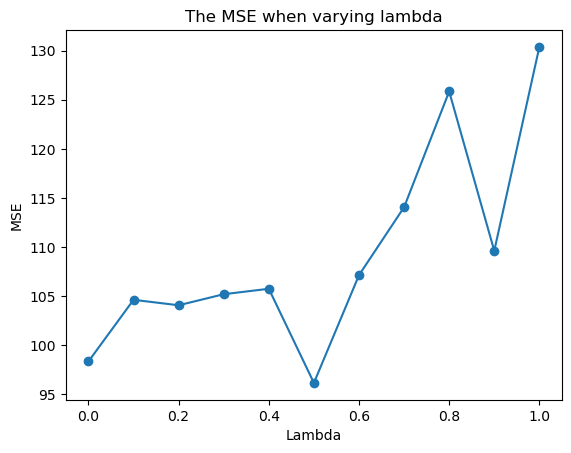

In [107]:
lambdas = list(mean_squared_errors.keys())
ms_errors = list(mean_squared_errors.values())

plt.plot(lambdas, ms_errors, marker='o')
plt.title('The MSE when varying lambda')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.show()

In [108]:
def plot_mse_against_episode_number(errors):
  plt.plot(errors)
  plt.xlabel('Episode number')
  plt.ylabel('Mean-squared error')
  plt.show()

### Plotting MSE for lambda=0 against episode number

Episode: 1000, score: 43.700000
Episode: 2000, score: 45.100000
Episode: 3000, score: 44.866667
Episode: 4000, score: 45.250000
Episode: 5000, score: 45.300000
Episode: 6000, score: 45.566667
Episode: 7000, score: 45.600000
Episode: 8000, score: 45.950000
Episode: 9000, score: 45.944444


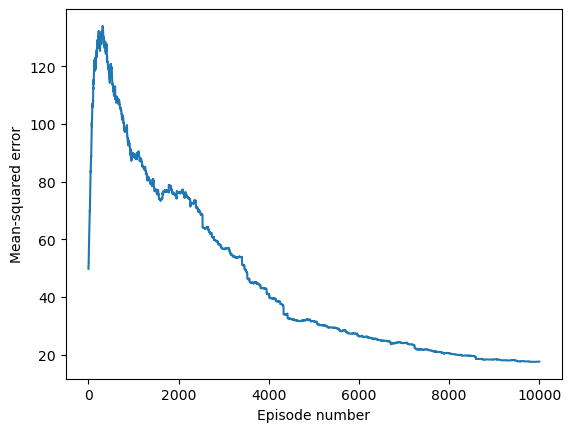

In [109]:
Q, mse_lambda_0 = sarsa_lambda(env, _lambda=0, num_episodes=10000)
plot_mse_against_episode_number(mse_lambda_0)

### Plotting MSE for lambda=1 against episode number

Episode: 1000, score: 44.900000
Episode: 2000, score: 46.200000
Episode: 3000, score: 46.133333
Episode: 4000, score: 46.175000
Episode: 5000, score: 46.740000
Episode: 6000, score: 46.650000
Episode: 7000, score: 46.914286
Episode: 8000, score: 46.862500
Episode: 9000, score: 46.855556


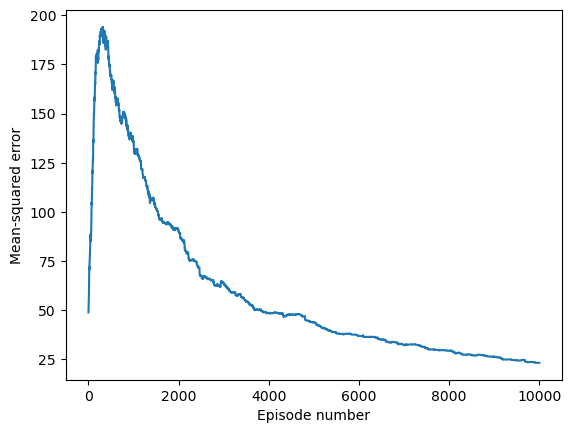

In [103]:
_, mse_lambda_1 = sarsa_lambda(env, _lambda = 1, num_episodes=10000)
plot_mse_against_episode_number(mse_lambda_1)